<a href="https://colab.research.google.com/github/Strongsoon/machineLearning/blob/main/kent_replicate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# <div align="center"><font color='green'> COSC 2673/2793 |  Machine Learning | Assignment 2 </font></div>
## <div align="center"> <font color='black'> Student Name: Chee Kin Go, Vincent Bethlehem </font></div>
## <div align="center"> <font color='red'> Student number: s3955624, s3899816 </font></div>
---

In [31]:
# To ensure Jupyter Notebook width size is same as your device viewport
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [32]:
# clone the repository to get the images locally
!git clone https://github.com/Strongsoon/machineLearning.git

fatal: destination path 'machineLearning' already exists and is not an empty directory.


# Problem statement

As a team of machine learning engineers at a biomedical startup, the goal is to build two separate classification model in analyzing histopathology images of colon cells:
- isCancerous Classification: Binary classification to determine whether a cell represents cancerous cells
- Cell-Type Classification: Multi-class classification to identify cell types (fibroblast, inflammatory, epithelial, or others)

Various classification models are implemented and evaluated:
- isCancerous Classification:
    - Baseline:
        - Logistic Regression
        - Neural Network (MLP)
    - Advanced:
        - Regularised Logistic Regression Model with Feature Selection
        - Neural Network (MLP) with L2 Regularisation, Dropout, Reduced Neurons

- Cell-Type Classification:
     - Baseline:
     - Advanced:

By the end of evaluation, We aim to select the best-performing model for each classification method with justification

## Exploratory Data Analysis (EDA)

Exploratory Data Analysis is the essential first step in the machine learning project which we perform initial investigations on data to:
 - Develop comprehensive understanding of dataset;
 - Reveal hidden patterns and feature relationship;
 - Spot outliers that might skew model performance;

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
import os

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set display options to show all columns
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Unlimited width
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines

# read csv file
mainColonCellFrame = pd.read_csv('https://raw.githubusercontent.com/Strongsoon/machineLearning/refs/heads/main/data_labels_mainData.csv', delimiter=',')

# print head
print(mainColonCellFrame.columns)

# print head
mainColonCellFrame.head()


Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')


,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


#### Data Loading
The data is loaded and abbreviated column names:
- **InstanceID**: Unique identifier for each individual cell instance
- **patientID**: Unique identifier for each patient. Multiple cells may come from the same patient
- **ImageName**: Filename of the image of the cell
- **cellTypeName**: Descriptive name of the cell type (epithelial, lymphocyte, fibroblast and others)
- **cellType**: Numeric code representing the cell type
- **isCancerous**: Binary indicator of Non-cancerous (0) and Cancerous (1) cell

<font color='green'> The target column is **isCancerous** and **cellType**.</font>
All the other columns are attributes.

In [34]:
# check for missing value
print("\nMissing values:")
print(pd.isna(mainColonCellFrame).sum())


Missing values:
InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64



#### No Missing Values
- No missing values found in the dataset

In [35]:
# display dataframe statistics
print("\nDataframe statistics:")
print(mainColonCellFrame.describe())


Dataframe statistics:
         InstanceID    patientID     cellType  isCancerous
count   9896.000000  9896.000000  9896.000000  9896.000000
mean   10193.880154    29.762025     1.501516     0.412187
std     6652.912660    17.486553     0.954867     0.492253
min        1.000000     1.000000     0.000000     0.000000
25%     4135.750000    14.000000     1.000000     0.000000
50%     9279.500000    26.000000     2.000000     0.000000
75%    16821.250000    47.000000     2.000000     1.000000
max    22444.000000    60.000000     3.000000     1.000000


#### Dataframe Statistics
Classification of Variables in the Dataset as obtained from the statistical summary above:
- Categorical Variables
    - Nominal Categorical Variables: cellType, cellTypeName, isCancerous

- Numerical Variables
    - Discrete Numerical Variables: InstanceID, patientID



Distribution for each variable:


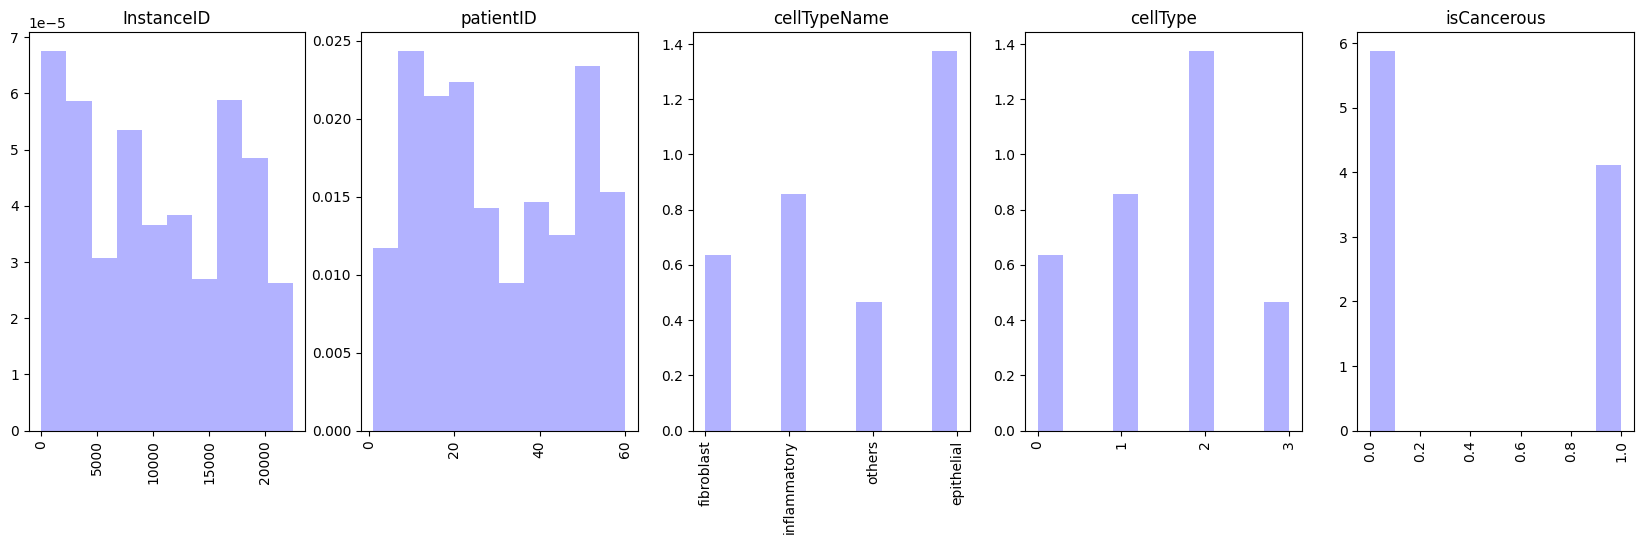

In [36]:
#Distirbution for each variable
print("\nDistribution for each variable:")
plt.figure(figsize=(25,30))
#didnt do image name because its not relevant
for i, col in enumerate([c for c in mainColonCellFrame.columns if c != 'ImageName']):
    plt.subplot(5, 6, i + 1)
    plt.hist(mainColonCellFrame[col], alpha=0.3, color='b', density=True)
    plt.title(col)
    plt.xticks(rotation='vertical')
plt.show()

#### Historgram Plot for Distribution Pattern for all variables
Reason:
- visualise data distirbution - shape, spread and central tendency to see if its normal, multimodal, or skewed.
- check the mean, mode and median using the overall shape
- check for outlier if there is unusual frequency in the ranges

Observation from Histogram Plot:
- InstanceID and PatientID are identifiers so dont really show any meaningful information
- CellTypeName and celltype both indicate that the epithelial cell is the most common compared to the others. This shows that the distribution of the cells aren't balanced
- isCancerous is a binary variable (0 for non-cancerous and 1 for cancerous). The histogram shows that there are more non-cancerous instances present
- There are no significant outliers present in the any of the histograms


Correlation Matrix between variables:


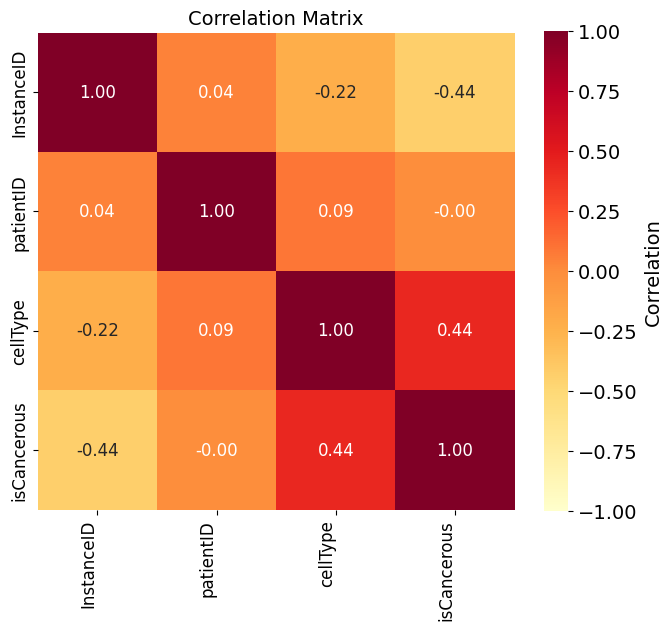

In [37]:
# Correlation Matrix between variables
print("\nCorrelation Matrix between variables:")
f, ax = plt.subplots(figsize=(7, 7))
numeric_df = mainColonCellFrame.select_dtypes(include='number')

corr = numeric_df.corr()

# Increase font sizes
plt.rcParams.update({'font.size': 14})  # Base font size
cbar_kws = {"shrink": 0.8, "label": "Correlation"}

# Create the heatmap with annotations and a famous color palette
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap="YlOrRd",  # Use the yellow-orange-red palette
    square=True,
    annot=True,  # This will print the values on the heatmap
    fmt=".2f",   # Format the annotations to 2 decimal places
    annot_kws={"size": 12},
    cbar_kws=cbar_kws
)

# Rotate x-axis labels for better readability
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right',
    fontsize=12
)
ax.set_yticklabels(
    ax.get_yticklabels(),
    fontsize=12
)

# Increase title font size
plt.title("Correlation Matrix", fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to make room for bigger fonts
plt.show()

#### Correlation Matrix between isCancerous and other variables
Reason:
- visualise how different variables relate with each other with its strength and direction (positive/negative)
- to spot multicollinearity by identifying extremely high correlations between predictors

Observations:
- Strong Predictors (|r| > 0.5):
    - None

- Moderate Predictors (0.3 < |r| < 0.5):
    - cellType: (0.44) (positive correlation)
    - instanceID: (-0.44) (negative correlation)

- Weak Predictors (|r| < 0.3):
    - patientID: (0.00) (no correlation)

<font color='red'>No presence of multicollinearity in the dataset</font>


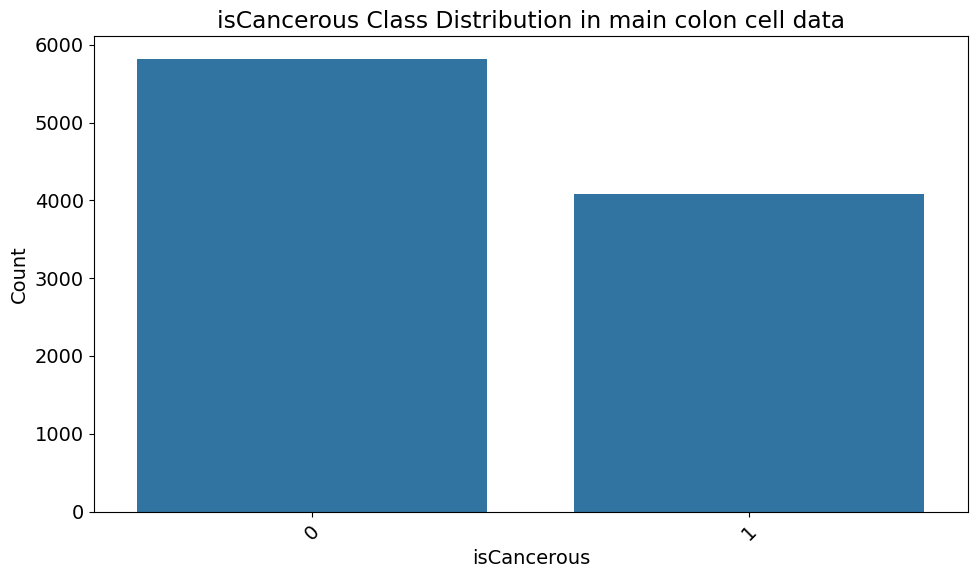

In [38]:
# isCancerous class distribution
plt.figure(figsize=(10,6))
sns.countplot(data=mainColonCellFrame, x='isCancerous', order=mainColonCellFrame['isCancerous'].value_counts().index)
plt.title('isCancerous Class Distribution in main colon cell data')
plt.xlabel('isCancerous')
plt.ylabel('Count')
plt.xticks(rotation=45)  # rotate if class names are long
plt.tight_layout()
plt.show()

#### isCancerous Class Distribution Plot
Reason:
- identify whether the dataset is balanced or imbalanced
- determine whether data resampling, or data augmentation is needed to address biases

Observations:
- Moderate level of class imblance present with approx 5800 non-cancerous instances, and approx 4,100 cancerous instances (ratio is 58:42)
- cancerous instance has a considerable portion in dataset, so classification methods can still work well with carefully selected evalutaiton metrics=


Relationship between isCancerous and other variables:


<Figure size 3000x5000 with 0 Axes>

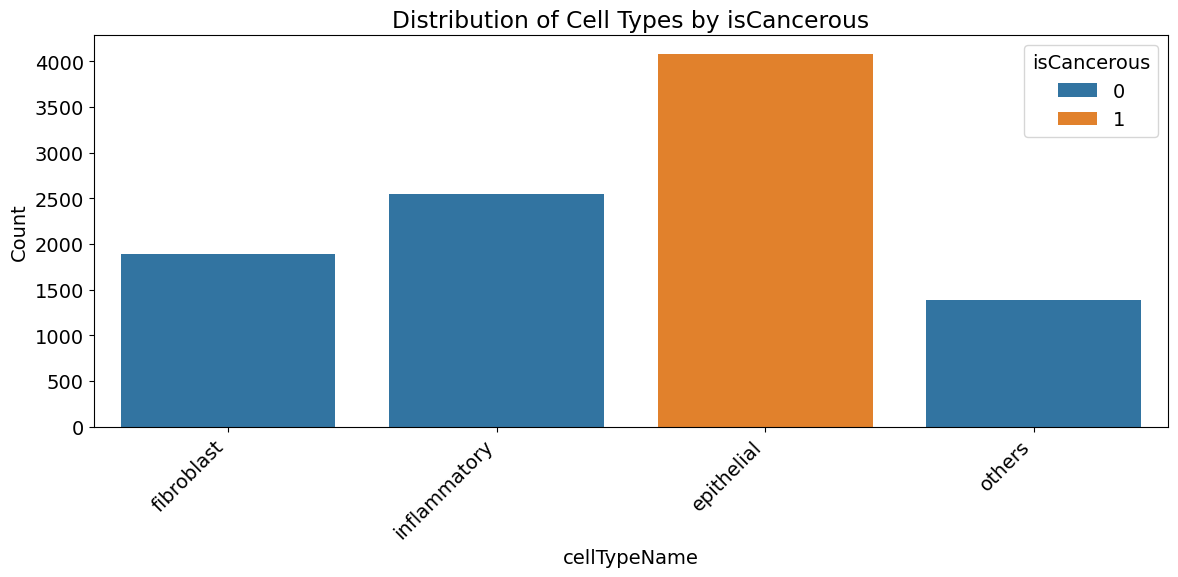

In [39]:
# Relationship between isCancerous and other variables
print("\nRelationship between isCancerous and other variables:")
plt.figure(figsize=(30,50))

# Create a mapping from cellTypeName to cellType
cell_type_mapping = mainColonCellFrame[['cellTypeName', 'cellType']].drop_duplicates().set_index('cellTypeName')['cellType']

# Sort cell types by their numeric cellType value
ordered_cell_types = cell_type_mapping.sort_values().index.tolist()

# Count plot for Distribution of Cell Types by isCancerous with explicit order
plt.figure(figsize=(12, 6))
sns.countplot(data=mainColonCellFrame, x='cellTypeName', hue='isCancerous', order=ordered_cell_types)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Cell Types by isCancerous')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Bar Chart for Distirbution for each Cell Type by isCancerous
Reason:
- Visualise which cell types are associated with cancerous status to be identified as potential predictive indicators which helps understand biological aspects of classification problem.

Observations:
- Cancer is only labeled in epithelial cells because all cancerous cells (100%) only present in epithelial cells (approx 4000 instances).
- Non-cancerous cells are distributed among fibroblast (approx 1900), inflammatory (approx 2500) and "others" cells (approx 1400). No epithelial cells are labeled as non-cancerous.

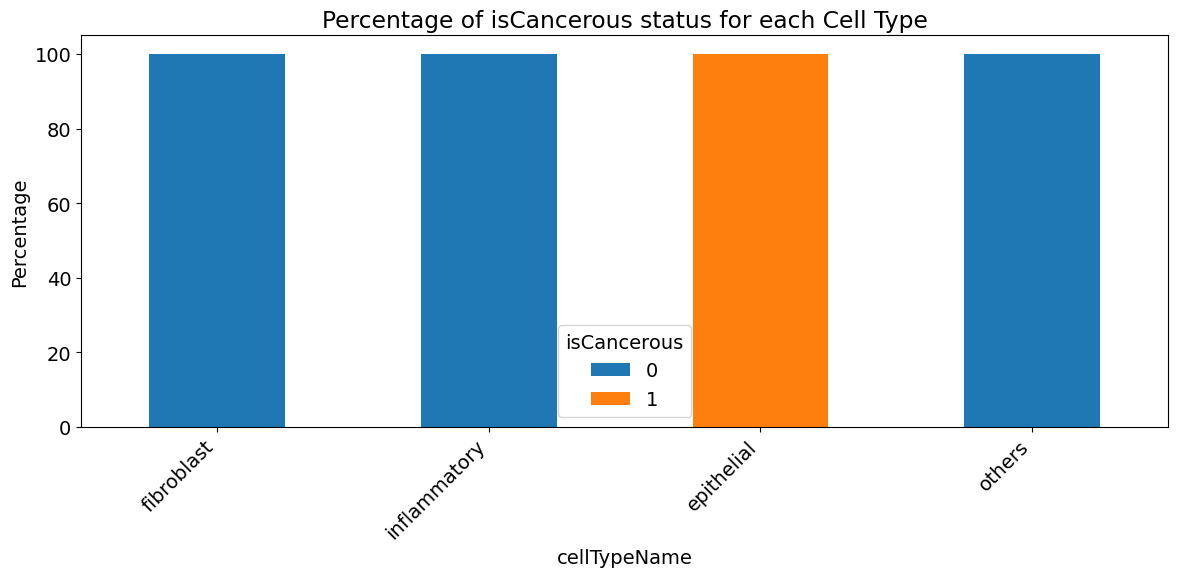

In [40]:
# Stacked bar chart with the same order
bar_chart_iscancerous_by_cell_type = pd.crosstab(
    mainColonCellFrame['cellTypeName'],
    mainColonCellFrame['isCancerous'],
    normalize='index'
).mul(100)

# Reindex the DataFrame to match the order based on cellType numeric value
bar_chart_iscancerous_by_cell_type = bar_chart_iscancerous_by_cell_type.reindex(ordered_cell_types)

bar_chart_iscancerous_by_cell_type.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.xticks(rotation=45, ha='right')
plt.title('Percentage of isCancerous status for each Cell Type')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()


#### Bar Chart for Percentage of isCancerous status for each Cell Type
Reason:
- Show the proportion of the isCancerous status distribution for each cell type regardless of its absolute counts

Observations:
- Confirms that 100% of epithelial cell are cancerous, and 100% of other cells are non-cancerous.
- Represents that there's a strong predictive relationship between cell type and isCancerous where identifying whether a cell is epithelial or not is enough to determine its cancerous status. Cell type could be used as criteria for classfication model.


Scatter plot between InstanceID and isCancerous for each Cell Type:


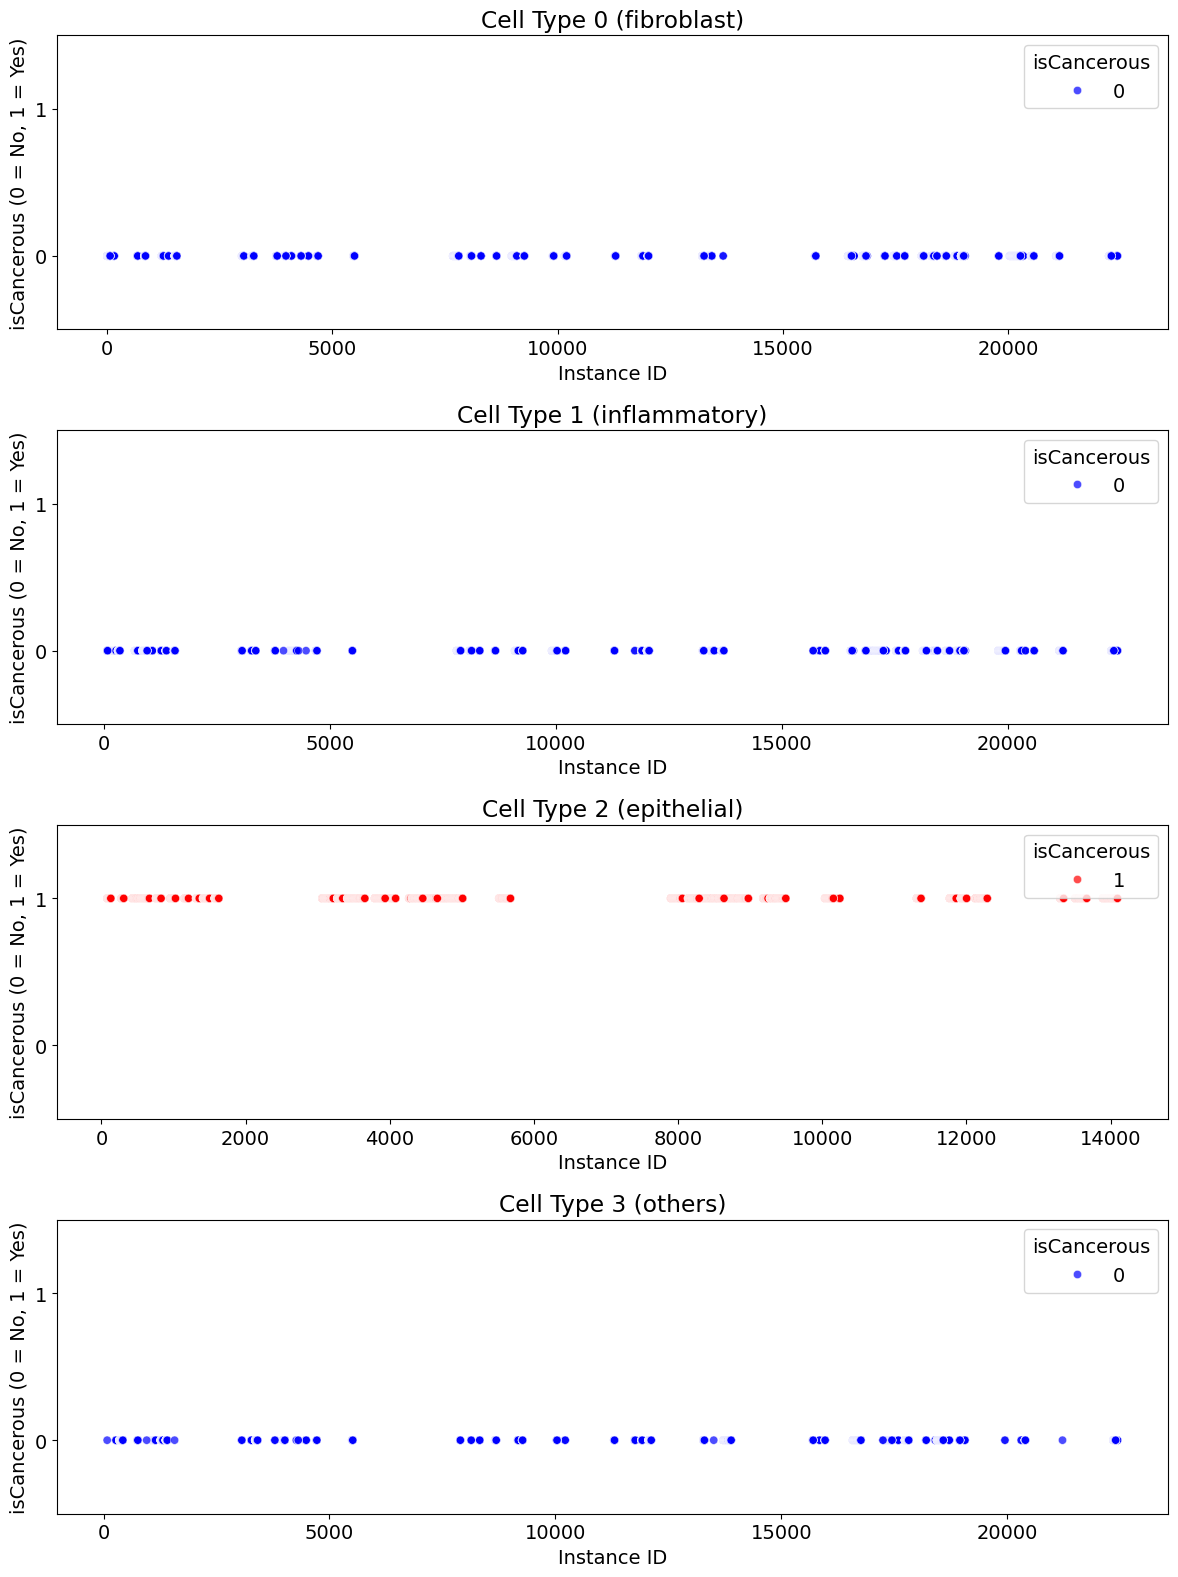

In [41]:
# Scatter plot between each cell type, PatientID and isCancerous
# Get unique cell types
mainColonCellFrame_unique_cell_types = mainColonCellFrame['cellType'].unique()

# Create a subplot for each cell type
fig, axes = plt.subplots(len(mainColonCellFrame_unique_cell_types), 1, figsize=(12, 4*len(mainColonCellFrame_unique_cell_types)))

# If there's only one cell type, axes won't be an array, so convert it to one
if len(mainColonCellFrame_unique_cell_types) == 1:
    axes = [axes]

# Create a scatter plot for each cell type
print("\nScatter plot between InstanceID and isCancerous for each Cell Type:")
for i, cell_type in enumerate(sorted(mainColonCellFrame_unique_cell_types)):
    # Filter data for current cell type
    cell_data = mainColonCellFrame[mainColonCellFrame['cellType'] == cell_type]

    # Get the cell type name for the title
    cell_type_name = cell_data['cellTypeName'].iloc[0] if not cell_data.empty else f"Type {cell_type}"


    # Create scatter plot
    sns.scatterplot(
        data=cell_data,
        x='InstanceID',
        y='isCancerous',
        hue='isCancerous',
        palette={0: 'blue', 1: 'red'},
        alpha=0.7,
        ax=axes[i]
    )

    # Set title and labels
    axes[i].set_title(f'Cell Type {cell_type} ({cell_type_name})')
    axes[i].set_xlabel('Instance ID')
    axes[i].set_ylabel('isCancerous (0 = No, 1 = Yes)')

    # Set y-axis to show only 0 and 1
    axes[i].set_yticks([0, 1])
    axes[i].set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()

#### Scatter plot between InstanceID and isCancerous for each Cell Type
Reason:
- Idenitfy pattern between distribution of instance identificatioin and isCancerous status for each cell type

Observations:
- Confirm previous obvservation where only epithelial cells are cancerous while others are non-cancerous
- Support previous asumption where there is predictive relationship between cell type and cancer status
- For non-epithelial cells, instanceID ranges from 0 to above 20000, while epithelial cells only until 14000. This suggests epithelial cells were collected differently or earlier during sample collection.
- Clustering of instanceID present across all cell types, suggest batch collection of sample collection. Cluster are seen in 0 to 20000, 5000, 10000, and between 15000 to 20000


Pairplot matrix between all variables with isCancerous hue:


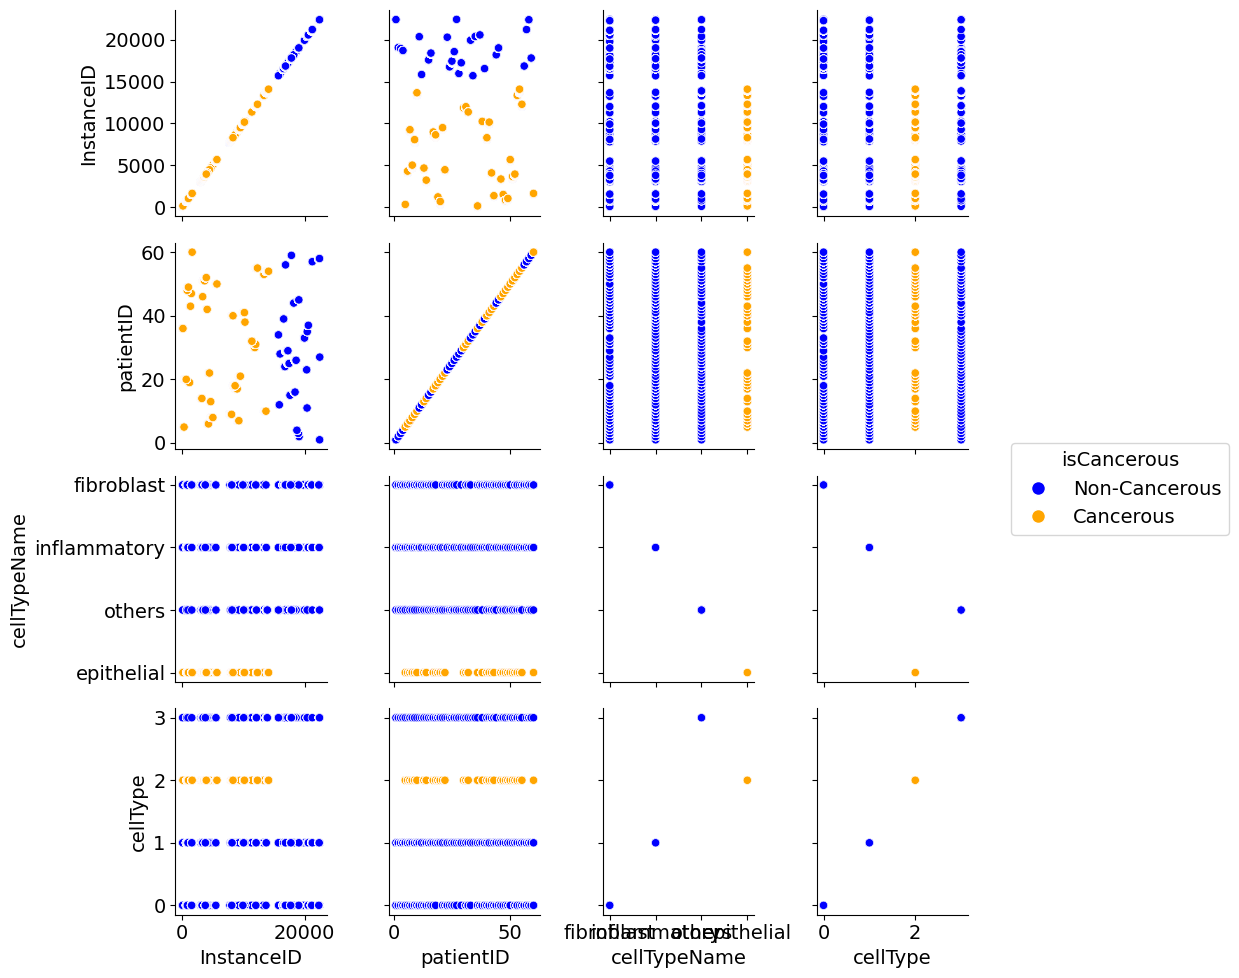

In [42]:
# Create a Pair plot for each variable with target variable hue (isCancerous)
print("\nPairplot matrix between all variables with isCancerous hue:")
isCancerous_pair_plot = sns.PairGrid(
    mainColonCellFrame,
    vars=['InstanceID', 'patientID', 'cellTypeName', 'cellType'],
    hue="isCancerous",
    palette={0: 'blue', 1: 'orange'}
)
isCancerous_pair_plot.map(sns.scatterplot)

# Remove auto-generated legends
for ax in isCancerous_pair_plot.axes.flat:
    if ax.get_legend() is not None:
        ax.get_legend().remove()

# Add legend
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=10)
]
isCancerous_pair_plot.fig.legend(
    custom_lines,
    ["Non-Cancerous", "Cancerous"],
    title="isCancerous",
    loc='center right',
    bbox_to_anchor=(1.25, 0.5)
)

plt.tight_layout()
plt.show()

#### Pairplot matrix between all variables with isCancerous hue:
Reason:
- visualise relationships between multiple variables simultaneously with cancer status as hue. Allow pattern to be identified that is not viewable in bivariate plots.
- check if non-linear or linear boundary can separate the two isCancerous classes

Observations:
- in patientID vs instanceID, and plots invloving cellType and cellTypeName, linear decision boundary can clearly separate the two classes
- None of the plot suggest non-linear decision boundary for class separation
- isCancerous clustering present in patientID where certain pateint has more cancerous samples, while other have more non-cancerous samples. This suggest there's biasness in patient selection when creating dataset.
- CellTypeName and CellType are highly correlated. cell type 2 corresponds to epithelial, while 0, 1, and 3 correspond to fibroblast, inflammatory, and other cells. This means feature removal can be performed as there is redundant feature.



Pairplot matrix between all variables with cellType hue:


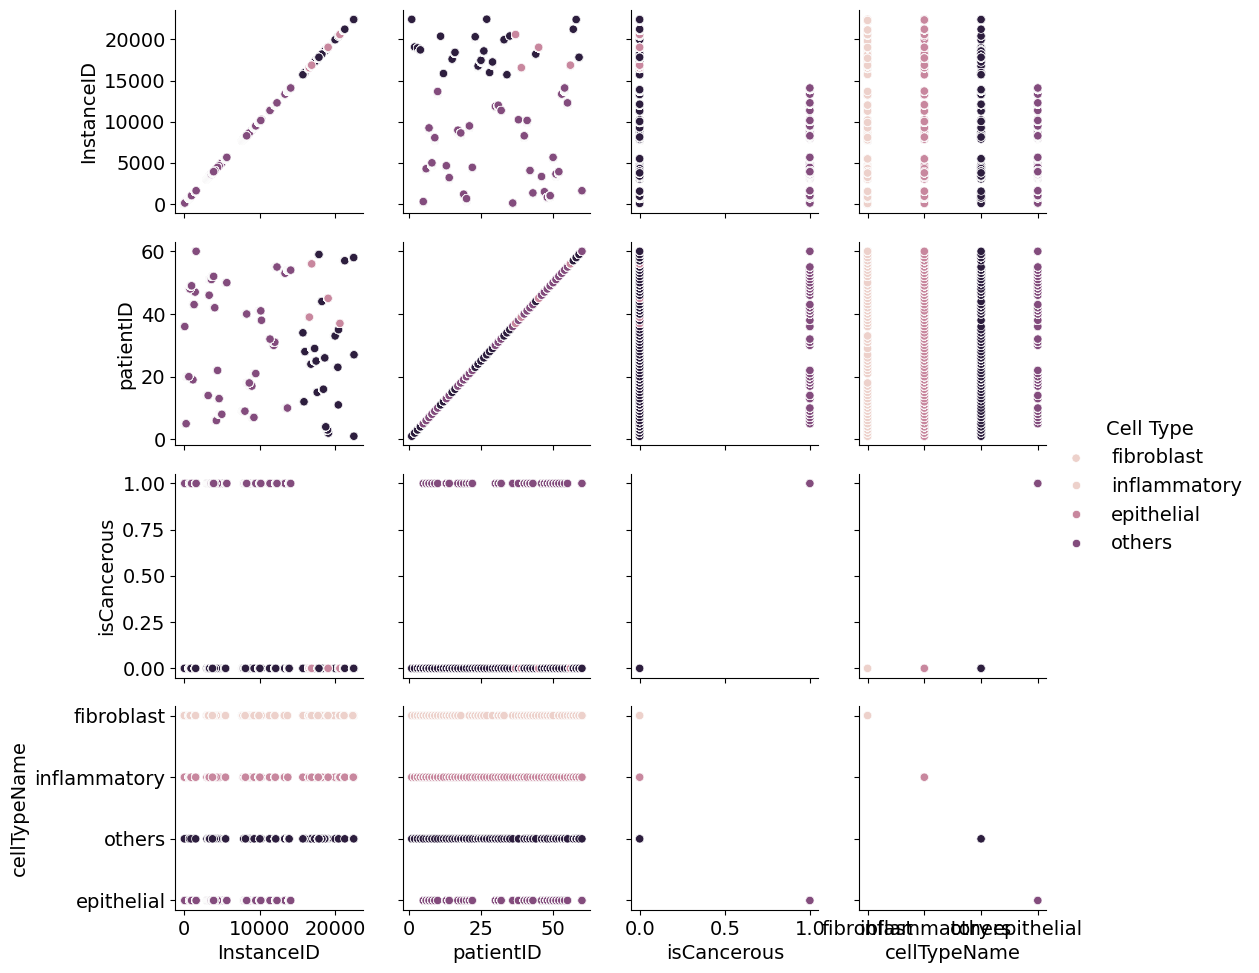

In [43]:
# Create a Pair plot for each variable with target variable hue (cellType)
print("\nPairplot matrix between all variables with cellType hue:")
cellType_pair_plot = sns.PairGrid(mainColonCellFrame, vars=['InstanceID','patientID', 'isCancerous', 'cellTypeName'], hue="cellType")
cellType_pair_plot.map(sns.scatterplot)

# Get unique cell type names for the legend
cell_type_labels = {
    cell_type: name
    for cell_type, name in zip(
        mainColonCellFrame['cellType'].unique(),
        mainColonCellFrame.drop_duplicates(subset=['cellType'])['cellTypeName']
    )
}
# Sort by cell type value
sorted_labels = [cell_type_labels[i] for i in sorted(cell_type_labels.keys())]

cellType_pair_plot.add_legend(title="Cell Type", labels=sorted_labels)
plt.show()

#### Pairplot matrix between all variables with cellType hue:
Reason:
- visualise relationships between variables and help detect any potential patterns, clusters or seperates based on CellType hue. This can help us identify if InstanceID, PatientID and isCancerous have any distinct behaviours surounding them that are noteworthy.
Observations:
- CellTypeName has clustering and should be ignored especially since it is categorical
- isCancerous show no sign of seperate by CellType meaning that if its cancerous its going to be spread across the different cell types
- InstanceId and PatientID are identifier variables (not very important)
- There is no real obvious linear relationship between the variables. This means there is very low correlation
- The colour hue differentiates the four different cell types quite well, but there isnt really distinct grouping that can be seen between these variables that can help seperate the cell types based on this.


Sample image for each cell type:


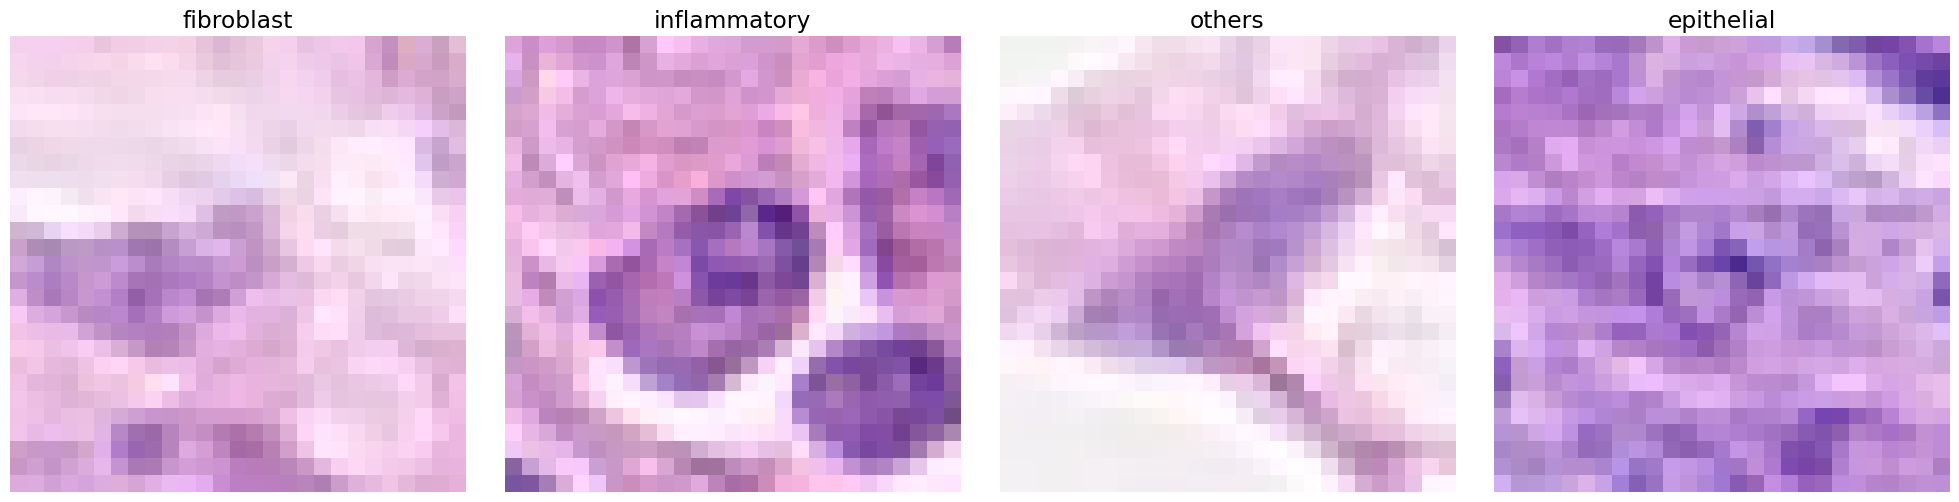

In [44]:
import urllib.request
from PIL import Image

print("\nSample image for each cell type:")
# unique cell type labels
mainColonCellFrame_cell_types = mainColonCellFrame['cellTypeName'].unique()
example_images = {}

# Choose random image
for cell in mainColonCellFrame_cell_types:
    one_row = mainColonCellFrame[mainColonCellFrame['cellTypeName'] == cell].sample(1)
    example_images[cell] = one_row['ImageName'].values[0]

# grid
fig, axes = plt.subplots(1, len(mainColonCellFrame_cell_types), figsize=(len(mainColonCellFrame_cell_types) * 5, 5))

# Loop selected image + display
for ax, (cell, filename) in zip(axes, example_images.items()):
    path = f"./machineLearning/patch_images/{filename}"  # Local path after cloning
    img = mpimg.imread(path)

    ax.imshow(img)
    ax.set_title(cell)
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Sample image for each cell type
Reason: The sample image printed out visually references what each cell type looks like under a microscope. This is a good way to see what we are dealing with.
Observations:
- Fibroblast: Shows a dark centre with lighter colours surrounding it
- Inflammatory: Shows some clustered cells around a center
- Others: No defined structure seems to be a misc cell type. There seems to be some shape present
- Epithelial: There seems to be some darker spots (nucleus?) which has a structured appearance

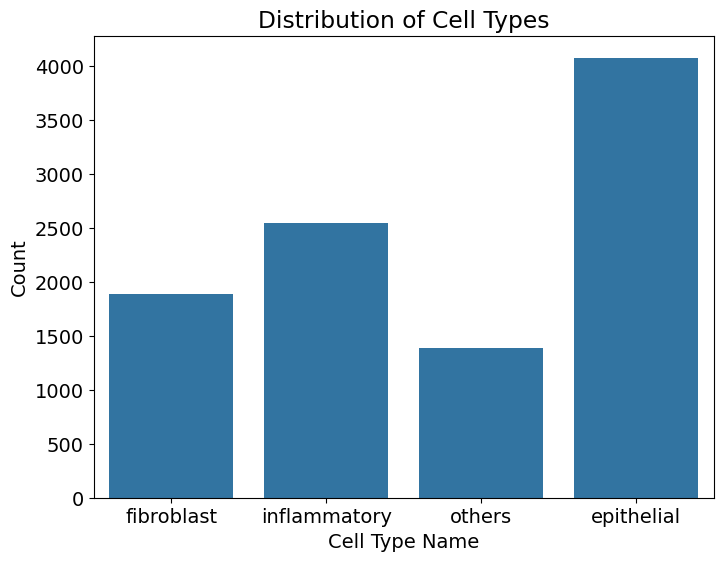

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(x='cellTypeName', data=mainColonCellFrame)
plt.title('Distribution of Cell Types')
plt.xlabel('Cell Type Name')
plt.ylabel('Count')
plt.show()

In [46]:
print(mainColonCellFrame['cellTypeName'].value_counts())

cellTypeName
epithelial      4079
inflammatory    2543
fibroblast      1888
others          1386
Name: count, dtype: int64


The distribution shows an inbalance where there is a lot more Epithelial than the rest. This means there may be bias present when predicting the Cell Type in future models. To mitigate this problem, there should be some pre processing to ensure there is a fair performance across the different cell types

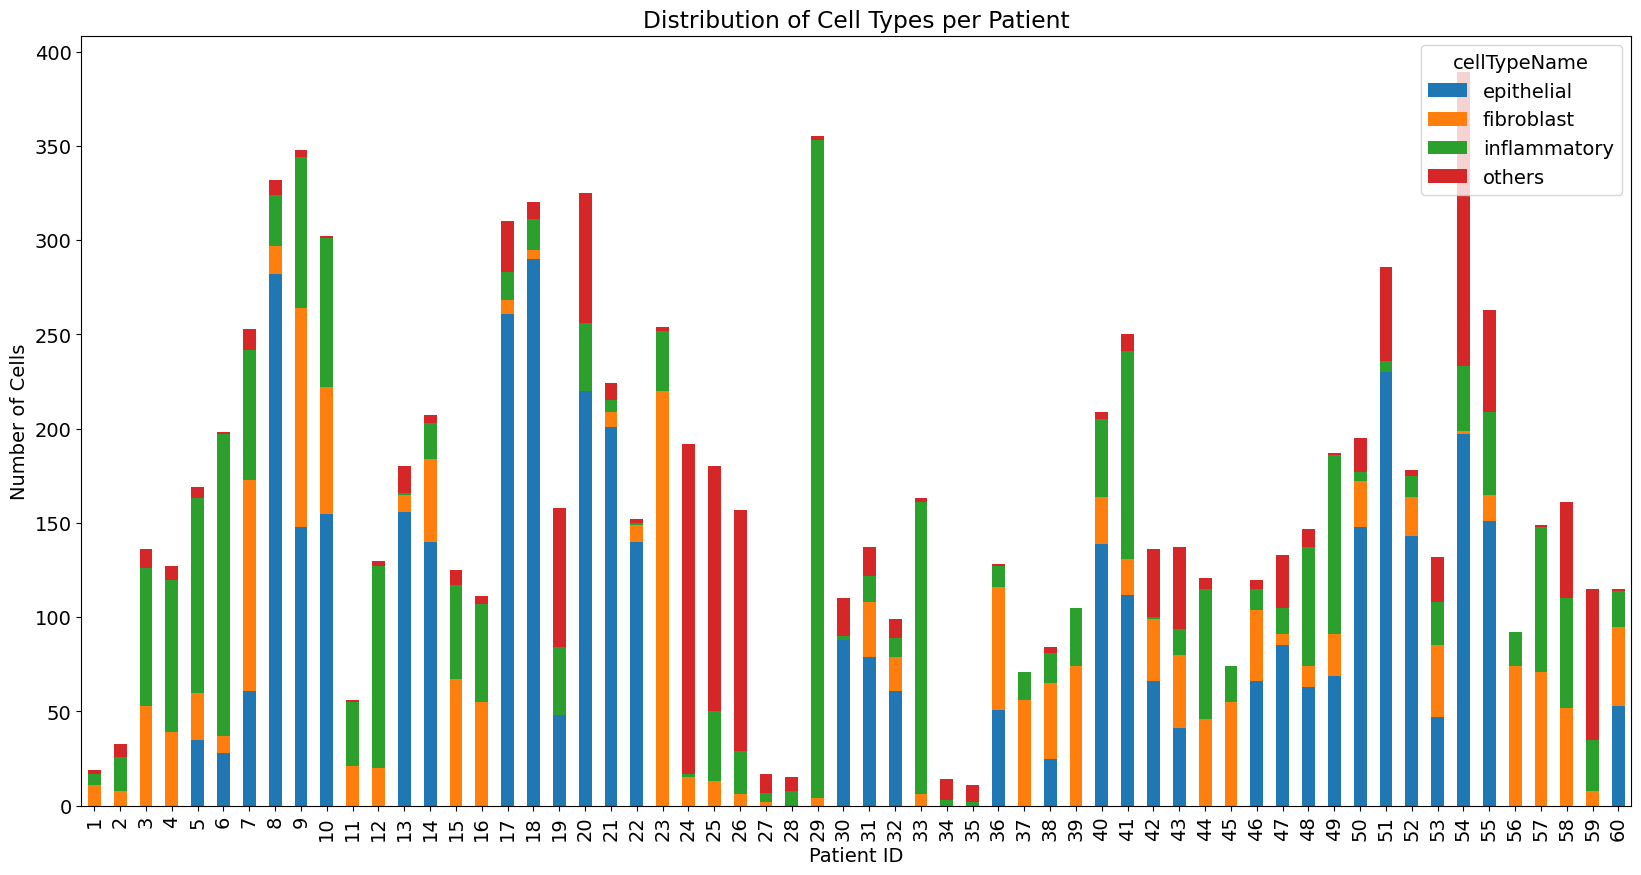

In [47]:
# Number of each cell type per patient
cell_counts = mainColonCellFrame.groupby(['patientID', 'cellTypeName']).size().reset_index(name='frequency')

# Cell type = columns and patients = rows
cell_pivot = cell_counts.pivot_table(index='patientID', columns='cellTypeName', values='frequency', fill_value=0)

# bar chart
ax = cell_pivot.plot.bar(stacked=True, figsize=(20, 10))

# labels
ax.set_title('Distribution of Cell Types per Patient')
ax.set_ylabel('Number of Cells')
ax.set_xlabel('Patient ID')

# Display the plot
plt.show()

In [48]:
#Copying the MainColonCellFrame to perform different different pre-processing
#This is because CellType can't be hot encoded as this is the Target Variable for the Cell Type Model
cellType_base_main_data = mainColonCellFrame.copy()

## Baseline development - Neural Network (MLP) for isCancerous

Neural Network (MLP) is chosen as baseline model because:
- MLP can automatically learn and recognise complex patterns from the raw pixel values of cell image without manual feature engineering
- MLP can identify visual indicators of cancer (texture, shape, and color) with Sigmoid activation function used in the hidden layer because model can learn non-linear relationship
- MLP establish performance benchmark, and foundation to scale to Convolutional Neural Networks to improve classification performance

Input dimension is 27x27x3 because colon cell image is 27×27 pixels with separate red, green, and blue values

Hidden layer has 256 neurons as starting point to balance computational efficiency and enough complexity to learn 2187 input values

Output class is 1 becayse suitable for binary classification for cancerous/non-cancerous with binary crossentropy (0 or 1 labels)

Use Sequential API because:
- build simple neural network where layers flow from input to hidden layers, and then output
- MLP doesn't require complex branching of inputs
- Easy to read and explain model

Sigmoid function is used because:
- has smooth gradient to learn differences between cancer and non-cancer cells
- stabilise learning rate because it outputs between 0 and 1
- provide starting points for baseline before using others like ReLU

In [49]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

INPUT_DIM = (27,27,3) # Each colon cell image is 27×27 pixels with separate red, green, and blue values for each pixel
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 1

isCancerous_base_nn_mlp_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM), # transforms the format of the images from a two-dimensional array (of 27 by 27 pixels) to a one-dimensional array (of 27 * 27 * 3 = 2187 pixels)
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

isCancerous_base_nn_mlp_model.summary()

2.18.0


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,385 (2.14 MB)

 Trainable params: 560,385 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Flatten Layer:
- Flattening 27×27×3 RGB image into 1D vector of 2187 values

Hidden Dense Layer:
- 560128 parameters (2187 inputs × 256 neurons + 256 bias terms) with sigmoid activation functionfor constrains neuron outputs between 0 and 1

Output Dense Layer:
- Raw logits with 257 parameters (256 inputs × 1 output + 1 bias term)
- Require loss function handling for model training to handle class imbalance

### Compile Model

Binary Cross-Entropy Loss function is use because:
- computes the cross-entropy loss between true labels and predicted labels for binary classification tasks, with the from_logits=True parameter handle conversion from raw model outputs to probabilities
- penalizes confident wrong predictions more heavily than less confident ones to avoid false negatives (missed cancer)

Adam Optimiser is use bacause:
- has features from stochastic gradient descent: AdaGrad and RMSprop to scale learning rate and use gradient's moving average to handle noise in image
- adapt learning rate for each parameter using graident history to handle error surface for class imbalance data

In [50]:
# f1-score
class f1Score(tf.keras.metrics.Metric):
  # Initialize the metric with a name and any additional arguments
    def __init__(self, name='f1_score', **kwargs):
       # Call parent class constructor with provided name and arguments
       super().__init__(name=name, **kwargs)
       # Create precision and recall metrics as internal components
       self.precision = tf.keras.metrics.Precision()
       self.recall = tf.keras.metrics.Recall()

   # Update the state of the metric with new predictions
    def update_state(self, y_true, y_pred, sample_weight=None):
       # Forward the update to both precision and recall metrics
       self.precision.update_state(y_true, y_pred, sample_weight)
       self.recall.update_state(y_true, y_pred, sample_weight)

   # Calculate the F1 score when requested
    def result(self):
       # Get the current precision and recall values
       p = self.precision.result()
       r = self.recall.result()
       # Calculate F1 score as the harmonic mean of precision and recall
       # Adding epsilon prevents division by zero
       return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

   # Reset the state of both precision and recall metrics
    def reset_state(self):
       # Clear accumulated values when starting a new epoch
       self.precision.reset_state()
       self.recall.reset_state()

# compile model
isCancerous_base_nn_mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        f1Score()
                    ])

### Date Splitting

#### train-validation-test splits strategy by patientID

Similar as previous model, we split by patientID using same random_state to <font color='red'>Prevent data leakage</font>:
- No patient has their cells split across different sets. Preserve independence between train, validation and test dataset

K-Fold Cross Validation splitting is not chosen due to CPU constraint as our computer does not have the CPU capacity to train classification models using cross validations

<font color='red'>Validation set assists in parameter tunning</font> on model to improve performance and  <font color='red'>prevent overffiting</font> because there is imbalance distirbution between cancerous and non-cancerous  as shown in isCancerous class distribution. We can find a right balance between precision and recall using validation set while preserve data integrity

In [51]:
# Data splitting - train-validation-test splits by patientID
print("\nisCancerous Base Model - Neural Network (MLP): Data Splitting into Train, Validation and Test set (by patientID):")

# make a copy
isCancerous_nn_mainColonCellFrame = mainColonCellFrame.copy()

# Get unique patient IDs
isCancerous_unique_patients = isCancerous_nn_mainColonCellFrame['patientID'].unique()

# Split patient IDs into train+val (80%) and test (20%)
isCancerous_train_patients, isCancerous_test_patients = train_test_split(isCancerous_unique_patients, test_size=0.2, random_state=42)

# Further split train+val into train (60% of total) and validation (20% of total)
isCancerous_train_patients, isCancerous_val_patients = train_test_split(isCancerous_train_patients, test_size=0.25, random_state=42)

# Create datasets based on patient assignment
with pd.option_context('mode.chained_assignment', None):
    # Assign samples to datasets based on which set their patient ID belongs to
    isCancerous_nn_train_data = isCancerous_nn_mainColonCellFrame[isCancerous_nn_mainColonCellFrame['patientID'].isin(isCancerous_train_patients)]
    isCancerous_nn_val_data = isCancerous_nn_mainColonCellFrame[isCancerous_nn_mainColonCellFrame['patientID'].isin(isCancerous_val_patients)]
    isCancerous_nn_test_data = isCancerous_nn_mainColonCellFrame[isCancerous_nn_mainColonCellFrame['patientID'].isin(isCancerous_test_patients)]

print(f"Training data: {len(isCancerous_nn_train_data)} samples from {len(isCancerous_train_patients)} patients")
print(f"Validation data: {len(isCancerous_nn_val_data)} samples from {len(isCancerous_val_patients)} patients")
print(f"Test data: {len(isCancerous_nn_test_data)} samples from {len(isCancerous_test_patients)} patients")


isCancerous Base Model - Neural Network (MLP): Data Splitting into Train, Validation and Test set (by patientID):
Training data: 5774 samples from 36 patients
Validation data: 2283 samples from 12 patients
Test data: 1839 samples from 12 patients


### Train Model

Convert isCancerous to String because Keras  ```flow_from_dataframe``` require labels in String format

keras ```flow_from_dataframe``` to load cell images directly from dataframe (which ImageName contains the image filename)
- x column: ImageName
- y column: isCancerous

Generator for train and validation can be use for both baseline and advanced model training.

use Keras ```model.fit_generator()``` to train the model.

In [52]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert isCancerous to String
isCancerous_nn_train_data['isCancerous'] = isCancerous_nn_train_data['isCancerous'].astype('str')
isCancerous_nn_val_data['isCancerous'] = isCancerous_nn_val_data['isCancerous'].astype('str')

# use Image data generators to load data in batch into memory
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

isCancerous_base_nn_mlp_train_generator = train_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_train_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

isCancerous_base_nn_mlp_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_val_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

Found 5774 validated image filenames belonging to 2 classes.
Found 2283 validated image filenames belonging to 2 classes.


In [ ]:
# train neural network model
history = isCancerous_base_nn_mlp_model.fit(isCancerous_base_nn_mlp_train_generator,
                                            validation_data = isCancerous_base_nn_mlp_validation_generator,
                                            epochs=50,
                                            verbose=0)

### Learning Curve

Learning curve is plot for loss, precision, recall and f1 because can <font color='red'>identify overfitting/underfitting</font>.

We apply optimisation technique in advanced development later.

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name):
    plt.figure(figsize=(18,7))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['precision'],
    history.history['val_precision'],
    metric_name='Precision'
)

Observations:
- Model is overfitting because Loss curve shows huge training-validation gap
- training loss decrease gradually at the end, while the validation loss remains high and fluctuating
- precision curve shows validation data has highly unstable with flunctuation

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['recall'],
    history.history['val_recall'],
    metric_name='Recall'
)

Observations:
- Model is overfitting because Loss curve shows huge training-validation gap
- Recall curves show validation outperform training although with high flunctuation
- high flunctuation shows model instability in geenralising to unseen data

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['f1_score'],
    history.history['val_f1_score'],
    metric_name='F1 Score'
)

Observations:
- Model is overfitting because Loss curve shows huge training-validation gap
- F1-score curve shows small gap between trainign and validation, with training F1 reach 0.85 and validation F1 hovers around 0.8
- Because F1-score combines precision and recall, f1 curve suggests model can classify unseen data moderately although overfitting

### Test Model

Test the trained model without hyperparameter tunning.

Generator for test data can be use for both baseline and advanced model training.


In [ ]:
# convert isCancerous to String
isCancerous_nn_test_data['isCancerous'] = isCancerous_nn_test_data['isCancerous'].astype('str')

# use Image data generators to load data in batch into memory
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

isCancerous_base_nn_mlp_test_generator = test_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_test_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

In [ ]:
# generate isCancerous label
isCancerous_label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

# plot output of neural network on testing data
d_inv = {v: k for k, v in isCancerous_label_names.items()}
plt.figure(figsize=(35,10))
batches = 0
for x,y in isCancerous_base_nn_mlp_test_generator:
        batches = batches + 1
        y_hat = isCancerous_base_nn_mlp_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 9:
            plt.subplot(2,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

Observations:
- Model classify correctly for first 8 non-cancerous cell

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Reset the generator to the beginning
isCancerous_base_nn_mlp_test_generator.reset()

# Calculate the number of steps needed to go through the entire test dataset
steps = len(isCancerous_nn_test_data) // batch_size
if len(isCancerous_nn_test_data) % batch_size != 0:
    steps += 1

# Collect all predictions and true labels
y_true = []
y_pred_raw = []

for i in range(steps):
    x, y = next(isCancerous_base_nn_mlp_test_generator)
    y_hat = isCancerous_base_nn_mlp_model.predict(x, verbose=0)

    # Collect true labels
    y_true.extend(y)

    # Collect raw predictions
    y_pred_raw.extend(y_hat)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_raw = np.array(y_pred_raw)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
# Calculate ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_raw)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Calculate metrics at each threshold
# f1_scores = []
# precision_scores = []
# recall_scores = []

# for threshold in thresholds_roc:
#     y_pred_threshold = (y_pred_raw >= threshold).astype(int)

#     # Calculate metrics
#     f1 = f1_score(y_true, y_pred_threshold)
#     precision = precision_score(y_true, y_pred_threshold)
#     recall = recall_score(y_true, y_pred_threshold)

#     f1_scores.append(f1)
#     precision_scores.append(precision)
#     recall_scores.append(recall)

# # Find threshold with best F1 score
# best_f1_idx = np.argmax(f1_scores)
# best_threshold = thresholds_roc[best_f1_idx]
# best_f1 = f1_scores[best_f1_idx]
# precision_at_best = precision_scores[best_f1_idx]
# recall_at_best = recall_scores[best_f1_idx]

# print(f"Best threshold: {best_threshold:.4f}")
# print(f"Best F1 score: {best_f1:.4f}")
# print(f"Precision at best threshold: {precision_at_best:.4f}")
# print(f"Recall at best threshold: {recall_at_best:.4f}")

# # Plot F1 scores against thresholds
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds_roc, f1_scores, label='F1 Score')
# plt.plot(thresholds_roc, precision_scores, label='Precision')
# plt.plot(thresholds_roc, recall_scores, label='Recall')
# plt.axvline(x=best_threshold, color='r', linestyle='--',
#             label=f'Best Threshold: {best_threshold:.4f}')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Metrics vs Threshold')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# convert to class labels (0 or 1)
y_pred_class = (y_pred_raw >= 0.5).astype(int)
print(classification_report(y_true, y_pred_class))

## Explanatory Model Analysis

#### ROC Curve
- baseline neural network (MLP) model has high AUC (0.93) for testing data. This confirm the model strong performance in classifying cencerous cell in various thresholds.

#### Macro Average Precision, Recall, F1-Score
- Testing Data:
    - Best threshold: -1.8069
    - Best F1 score: 0.8636
    - Precision at best threshold: 0.8215
    - Recall at best threshold: 0.9103

Observations:
- Model has strong classification performance with F1-score 0.8636 at optimal threshold, along with
- Higher recall than precision means model prioritize in identifying actual cancerous cells over minimizing false positives because missing actual cancerous cases is concern
- negative threshold because isCanceorus class imabalance in training data

## Advanced development - Neural Network (MLP) with L2 Regularisation, Dropout, Reduced Neurons for isCancerous

Because of overfitting, we improved baseline neural network by applying:
- L2 Regularisation: penalizes large weights without turning to exactly zero to preserve cell image data features
- Dropout:
    - randomly deactivates neurons during training because Huge training-validation gap in loss curve show model memorising data
    - 0.3 dropout rate in hidden layer with more neurons helps reduce overfitting in the larger parameter space
- Reduce neurones in layer:
    - baseline  256 neurons create 500000 parameters, making overfitting highly likely
    - reducing to 128 neurons decreases model capacity while maintaining sufficient performance

In [ ]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 128 # Reduced from 256 to 128
OUTPUT_CLASSES = 1

isCancerous_advanced_nn_mlp_model  = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    # add L2 regularization to hidden layer
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid',
                         kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    # add dropout
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])
print("Advanced:")
isCancerous_advanced_nn_mlp_model.summary()

```
Baseline:
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 flatten (Flatten)           (None, 2187)              0         
                                                                 
 dense (Dense)               (None, 256)               560128    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
=================================================================
Total params: 560,385
Trainable params: 560,385
Non-trainable params: 0
_________________________________________________________________
```
Flatten Layer:
- Same as baseline with 1D vector of 2187 values

First Dense Layer:
- Neurons is reduced by 505 from 256 to 1288. Decrease model capacity in memorising training data to solve overfitting.

Dropout Layer:
- Baseline didn't have this. Dropout deactivate random neurons during training to prevent adaptation, make model include robust feature learning.

Output Layer:
- Same as baseline use single output neuron for isCancerous binary classification

Total Parameters:
- advanced model has only 50% of the baseline's parameters, making it significantly less prone to overfitting

### Compile and Train Model

The model is compiled and trained.

In [ ]:
# compile model
isCancerous_advanced_nn_mlp_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[
                        tf.keras.metrics.Precision(name='precision'),
                        tf.keras.metrics.Recall(name='recall'),
                        tf.keras.metrics.AUC(name='auc'),
                        f1Score()
                    ])

# convert isCancerous to String
isCancerous_nn_train_data['isCancerous'] = isCancerous_nn_train_data['isCancerous'].astype('str')
isCancerous_nn_val_data['isCancerous'] = isCancerous_nn_val_data['isCancerous'].astype('str')

# use Image data generators to load data in batch into memory
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

isCancerous_advanced_nn_mlp_train_generator = train_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_train_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

isCancerous_advanced_nn_mlp_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_val_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

# train neural network model
history = isCancerous_advanced_nn_mlp_model.fit(isCancerous_advanced_nn_mlp_train_generator,
                                            validation_data = isCancerous_advanced_nn_mlp_validation_generator,
                                            epochs=50,
                                            verbose=0)

### Learning Curve

Learning curve is plot for loss, precision, recall and f1 because to <font color='red'>check overfitting</font>.

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['precision'],
    history.history['val_precision'],
    metric_name='Precision'
)

Compare to Baseline:
- Loss curve shows Advanced model has reduced overfitting with narrower training-validation gap because dropout and reduced neuron solve overfitting issue.
- Advnaced model maintain similar precision levels to baseline with 50% less parameters. Means baseline is overparameterized

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['recall'],
    history.history['val_recall'],
    metric_name='Recall'
)

Compare to Baseline:
- Loss curve shows Advanced model has reduced overfitting with narrower training-validation gap because dropout and reduced neuron solve overfitting issue.
- Advnaced model validation outperforming training recall which is different to baseline where recall pattern is more conventional.
- validation recall shows fluctuations between 0.35 and 0.90 because model still unstable aftre optimisied
- training recall (0.70) is lower than baseline (0.80) because regularisation, dropout, and reduced neurons prevent model from fitting perfectly to training data for better generalisation.

In [ ]:
plot_learning_curve(
    history.history['loss'],
    history.history['val_loss'],
    history.history['f1_score'],
    history.history['val_f1_score'],
    metric_name='F1 Score'
)

Compare to Baseline:
- Loss curve shows Advanced model has reduced overfitting with narrower training-validation gap because dropout and reduced neuron solve overfitting issue.
- Advanced model has consistent validation F1-scores outperforming training's which is different to baseline's  training F1-scores exceeded validation F1-scores.
- Advanced model maintains similar F1-score to baseline (0.76 to 0.84) with 50% less parameter. Confirms reduced parameter can acheive equivalent performance.

### Test Model

Test the trained model with hyperparameter tunning (L2 Regularisation, Dropout, Reduced Neurons)

In [ ]:
# generate isCancerous label
isCancerous_label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

# convert isCancerous to String
isCancerous_nn_test_data['isCancerous'] = isCancerous_nn_test_data['isCancerous'].astype('str')

# use Image data generators to load data in batch into memory
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

isCancerous_advanced_nn_mlp_test_generator = test_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_test_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

# plot output of neural network on testing data
d_inv = {v: k for k, v in isCancerous_label_names.items()}
plt.figure(figsize=(35,10))
batches = 0
for x,y in isCancerous_advanced_nn_mlp_test_generator:
        batches = batches + 1
        y_hat = isCancerous_advanced_nn_mlp_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 9:
            plt.subplot(2,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

Observations:
- Same as baseline, Model classify correctly for first 8 non-cancerous cell

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Reset the generator to the beginning
isCancerous_advanced_nn_mlp_test_generator.reset()

# Calculate the number of steps needed to go through the entire test dataset
steps = len(isCancerous_nn_test_data) // batch_size
if len(isCancerous_nn_test_data) % batch_size != 0:
    steps += 1

# Collect all predictions and true labels
y_true = []
y_pred_raw = []

for i in range(steps):
    x, y = next(isCancerous_advanced_nn_mlp_test_generator)
    y_hat = isCancerous_advanced_nn_mlp_model.predict(x, verbose=0)

    # Collect true labels
    y_true.extend(y)

    # Collect raw predictions
    y_pred_raw.extend(y_hat)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_raw = np.array(y_pred_raw)

In [ ]:
# Calculate ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_raw)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# # Calculate metrics at each threshold
# f1_scores = []
# precision_scores = []
# recall_scores = []

# for threshold in thresholds_roc:
#     y_pred_threshold = (y_pred_raw >= threshold).astype(int)

#     # Calculate metrics
#     f1 = f1_score(y_true, y_pred_threshold)
#     precision = precision_score(y_true, y_pred_threshold)
#     recall = recall_score(y_true, y_pred_threshold)

#     f1_scores.append(f1)
#     precision_scores.append(precision)
#     recall_scores.append(recall)

# # Find threshold with best F1 score
# best_f1_idx = np.argmax(f1_scores)
# best_threshold = thresholds_roc[best_f1_idx]
# best_f1 = f1_scores[best_f1_idx]
# precision_at_best = precision_scores[best_f1_idx]
# recall_at_best = recall_scores[best_f1_idx]

# print(f"Best threshold: {best_threshold:.4f}")
# print(f"Best F1 score: {best_f1:.4f}")
# print(f"Precision at best threshold: {precision_at_best:.4f}")
# print(f"Recall at best threshold: {recall_at_best:.4f}")

# # Plot F1 scores against thresholds
# plt.figure(figsize=(10, 6))
# plt.plot(thresholds_roc, f1_scores, label='F1 Score')
# plt.plot(thresholds_roc, precision_scores, label='Precision')
# plt.plot(thresholds_roc, recall_scores, label='Recall')
# plt.axvline(x=best_threshold, color='r', linestyle='--',
#             label=f'Best Threshold: {best_threshold:.4f}')
# plt.xlabel('Threshold')
# plt.ylabel('Score')
# plt.title('Metrics vs Threshold')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# convert to class labels (0 or 1)
y_pred_class = (y_pred_raw >= 0.5).astype(int)
print(classification_report(y_true, y_pred_class))

## Explanatory Model Analysis

#### ROC Curve
<!-- - baseline neural network (MLP) model has high AUC (0.93) for testing data. This confirm the model strong performance in classifying cencerous cell in various thresholds.
 -->
#### Macro Average Precision, Recall, F1-Score
- Baseline Testing Data:
    - Best threshold: -1.8069
    - Best F1 score: 0.8636
    - Precision at best threshold: 0.8215
    - Recall at best threshold: 0.9103
- Advanced Testing Data:
    - Best threshold: -0.6672
    - Best F1 score: 0.8593
    - Precision at best threshold: 0.8737
    - Recall at best threshold: 0.8454

Observations:
<!-- - Model has strong classification performance with F1-score 0.8618 at optimal threshold, along with
- Higher recall than precision means model prioritize in identifying actual cancerous cells over minimizing false positives because missing actual cancerous cases is concern
- negative threshold because isCanceorus class imabalance in training data -->

## Baseline development - Deep Neural Network (CNN) for isCancerous

Deep Neural Network (CNN) is chosen as baseline model because CNN solve MLP limitations. CNN:
- eliminate manual feature engineering by automating the feature extraction using learned convolution filters
- use local connectivity and parameter sharing to reduce parameter for increased input sizes (MLP suffer from increased complexity)
- use ReLU activation to eliminate saturation caused from Sigmoid (which used by MLP), and compute faster
- use sparse connectivity to reduce model complexity,a nd detect important feature. More efficient than MLP
- scale better through hierarchical feature construction for increasingly complex representations

Input dimension is 27x27x3 because colon cell image is 27×27 pixels with separate red, green, and blue values

Output class is 1 becayse suitable for binary classification for cancerous/non-cancerous with binary crossentropy (0 or 1 labels)

Convolutional layers is used because feature extraction

Max pooling for dimensionality reduction

ReLU is used because:
- eliminate saturation caused from Sigmoid (which used by MLP)
- propagates gradients more efficiently for complex model

In [ ]:
import tensorflow as tf

INPUT_DIM = (27,27,3) # Each colon cell image is 27×27 pixels with separate red, green, and blue values for each pixel
OUTPUT_CLASSES = 1

isCancerous_base_cnn_model = tf.keras.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),  # Dimension reduction

    # Second convolutional block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)), # Dimension reduction

    # Flatten feature maps
    tf.keras.layers.Flatten(),

    # Fully connected layers for classification
    tf.keras.layers.Dense(64, activation='relu'),

    # Output layer
    tf.keras.layers.Dense(OUTPUT_CLASSES),  # Binary classification output
])

isCancerous_base_cnn_model.summary()

First Convulational Block:
- Conv2D: Applies 32 filters of size 3x3 to shrinks image to 25x25
- MaxPooling2D: Downsamples feature maps using max 2x2 pooling

Second Convulational Block:
- Conv2D: Applies 64 filters of size 3x3 to downsampled feature maps
- MaxPooling2D: Downsamples again using max 2x2 pooling

Flatten Layer:
- Flattening 3D feature maps to 1D vector of 1600 values

Dense Layer:
- Fully connected layer with 64 neurons

Output Dense Layer:
- Output layer with 1 neuron for binary classification

### Compile Model

Binary Cross-Entropy Loss function is use because:
- computes the cross-entropy loss between true labels and predicted labels for binary classification tasks, with the from_logits=True parameter handle conversion from raw model outputs to probabilities
- penalizes confident wrong predictions more heavily than less confident ones to avoid false negatives (missed cancer)

Adam Optimiser is use bacause:
- has features from stochastic gradient descent: AdaGrad and RMSprop to scale learning rate and use gradient's moving average to handle noise in image
- adapt learning rate for each parameter using graident history to handle error surface for class imbalance data

In [ ]:
# f1-score
class f1Score(tf.keras.metrics.Metric):
  # Initialize the metric with a name and any additional arguments
    def __init__(self, name='f1_score', **kwargs):
       # Call parent class constructor with provided name and arguments
       super().__init__(name=name, **kwargs)
       # Create precision and recall metrics as internal components
       self.precision = tf.keras.metrics.Precision()
       self.recall = tf.keras.metrics.Recall()

   # Update the state of the metric with new predictions
    def update_state(self, y_true, y_pred, sample_weight=None):
       # Forward the update to both precision and recall metrics
       self.precision.update_state(y_true, y_pred, sample_weight)
       self.recall.update_state(y_true, y_pred, sample_weight)

   # Calculate the F1 score when requested
    def result(self):
       # Get the current precision and recall values
       p = self.precision.result()
       r = self.recall.result()
       # Calculate F1 score as the harmonic mean of precision and recall
       # Adding epsilon prevents division by zero
       return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

   # Reset the state of both precision and recall metrics
    def reset_state(self):
       # Clear accumulated values when starting a new epoch
       self.precision.reset_state()
       self.recall.reset_state()

isCancerous_base_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # As used in slide 5
    metrics=[tf.keras.metrics.Precision(name='precision'),
              tf.keras.metrics.Recall(name='recall'),
              tf.keras.metrics.AUC(name='auc'),
              f1Score()]
)

### Train Model

Convert isCancerous to String because Keras  ```flow_from_dataframe``` require labels in String format

keras ```flow_from_dataframe``` to load cell images directly from dataframe (which ImageName contains the image filename)
- x column: ImageName
- y column: isCancerous

Generator for train and validation can be use for both baseline and advanced model training.

use Keras ```model.fit_generator()``` to train the model.

In [ ]:
# use Image data generators to load data in batch into memory
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 27

isCancerous_base_cnn_train_generator = train_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_train_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

isCancerous_base_cnn_validation_generator = val_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_val_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

isCancerous_base_cnn_history = isCancerous_base_cnn_model.fit(isCancerous_base_cnn_train_generator,
                                            validation_data = isCancerous_base_cnn_validation_generator,
                                            epochs=50,
                                            verbose=0)

### Learning Curve

Learning curve is plot for loss, precision, recall and f1 because can <font color='red'>identify overfitting/underfitting</font>.

We apply optimisation technique in advanced development later.

In [ ]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name):
    plt.figure(figsize=(18,7))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
plot_learning_curve(
    isCancerous_base_cnn_history.history['loss'],
    isCancerous_base_cnn_history.history['val_loss'],
    isCancerous_base_cnn_history.history['precision'],
    isCancerous_base_cnn_history.history['val_precision'],
    metric_name='Precision'
)

In [ ]:
plot_learning_curve(
    isCancerous_base_cnn_history.history['loss'],
    isCancerous_base_cnn_history.history['val_loss'],
    isCancerous_base_cnn_history.history['recall'],
    isCancerous_base_cnn_history.history['val_recall'],
    metric_name='Recall'
)

In [ ]:
plot_learning_curve(
    isCancerous_base_cnn_history.history['loss'],
    isCancerous_base_cnn_history.history['val_loss'],
    isCancerous_base_cnn_history.history['f1_score'],
    isCancerous_base_cnn_history.history['val_f1_score'],
    metric_name='F1 Score'
)

### Test Model

Test the trained model without hyperparameter tunning.

Generator for test data can be use for both baseline and advanced model training.


In [ ]:
# generate isCancerous label
isCancerous_label_names = {'Non-Cancerous' : 0, 'Cancerous' : 1}

# convert isCancerous to String
isCancerous_nn_test_data['isCancerous'] = isCancerous_nn_test_data['isCancerous'].astype('str')

# use Image data generators to load data in batch into memory
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

isCancerous_base_cnn_test_generator = test_datagen.flow_from_dataframe(
        dataframe=isCancerous_nn_test_data,
        directory='./machineLearning/patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

# plot output of neural network on testing data
d_inv = {v: k for k, v in isCancerous_label_names.items()}
plt.figure(figsize=(35,10))
batches = 0
for x,y in isCancerous_base_cnn_test_generator:
        batches = batches + 1
        y_hat = isCancerous_base_cnn_model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 9:
            plt.subplot(2,4,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))

        else:
            break

        plt.axis('off')

In [ ]:
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve

# Reset the generator to the beginning
isCancerous_base_cnn_test_generator.reset()

# Calculate the number of steps needed to go through the entire test dataset
steps = len(isCancerous_nn_test_data) // batch_size
if len(isCancerous_nn_test_data) % batch_size != 0:
    steps += 1

# Collect all predictions and true labels
y_true = []
y_pred_raw = []

for i in range(steps):
    x, y = next(isCancerous_base_cnn_test_generator)
    y_hat = isCancerous_base_cnn_model.predict(x, verbose=0)

    # Collect true labels
    y_true.extend(y)

    # Collect raw predictions
    y_pred_raw.extend(y_hat)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_raw = np.array(y_pred_raw)

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, auc
# Calculate ROC curve and ROC area
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_raw)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# convert to class labels (0 or 1)
y_pred_class = (y_pred_raw >= 0.5).astype(int)
print(classification_report(y_true, y_pred_class))